In [254]:
#default_exp corner_detection_inference

In [199]:
#export
from ocr.corner_detection_training import *
from ocr.corner_detection_training import input_shape
from ocr.core import load_inference
from fastai import *
from fastai.vision import *
from fastai.vision import Image
from torch.nn import functional as F
import cv2
import matplotlib.pyplot as plt

In [216]:
learner = load_inference('unet_paper_mask')

In [3]:
def plot(im):
    ax = plt.figure()
    if len(im.squeeze().shape) == 2: plt.imshow(im, cmap='gray')
    else: plt.imshow(im)
    return plt.show()

In [4]:
DATASET_PATH = "../data/corner_detection"
filenames = [
    DATASET_PATH+'/smartdoc15-ch1_home/frames/background01/datasheet001/frame_0034.jpeg',
    DATASET_PATH+'/smartdoc15-ch1_home/frames/background02/datasheet001/frame_0034.jpeg',
    DATASET_PATH+'/smartdoc15-ch1_home/frames/background03/datasheet001/frame_0034.jpeg',
    DATASET_PATH+'/smartdoc15-ch1_home/frames/background04/datasheet001/frame_0034.jpeg',
    DATASET_PATH+'/smartdoc15-ch1_home/frames/background05/datasheet001/frame_0034.jpeg',
]
imgs = list(map(lambda x: cv2.imread(x), filenames))

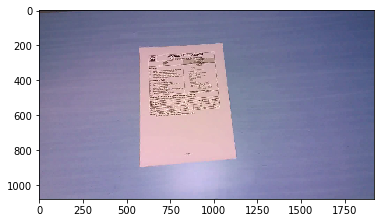

In [5]:
plot(imgs[0])

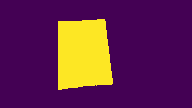

In [7]:
im = imgs[0]
im = im[ :, :, [2,1,0] ] # BGR -> RGB
im = cv2.resize(im, (192,108))
im = Image(tensor(im).permute(2,0,1).float() / 255.)

learner.model.eval()
pred = learner.predict(im)
pred[0]

In [278]:
#export
class PaperCornerPredictor:
    def __init__(self, model_name='unet_paper_mask', use_unet=False, use_gpu=True, trained_input_shape=input_shape):
        '''
        @param: str       :name of model in ../models dir
        @param: bool      :use mask from unet? (unet ~800mb)
        @param: np.arr[2] :[height, width] of image (when training)
        '''
        self.model_name, self.use_gpu = model_name, use_gpu
        if self.use_gpu: defaults.device = torch.device('cuda')
        else: defaults.device = torch.device('cpu')
        if use_unet: self.learner = load_inference(model_name)
        self.train_shape = trained_input_shape
        self.use_unet = use_unet
        
    def predict_corners(self, image, shape='train'):
        ''' 
        @param: torch.arr [h,w,3] :(make sure its in RGB not BGR!)
        @param: np.arr [2] :[height, width] of nn input (if None leaves the same, if 'train' leaves self.train_shape)
        @return torch.arr [8] :[tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y]
        '''
        # preprocess image
        if image.size(2) == 3: image = image.permute(2,0,1) # [3,h,w]
        orig_shape = image.shape[1:] # [2]
        if shape is not None:
            shape = shape if shape != 'train' else self.train_shape
            if len(image.shape) == 3: image = image[None]
            image = F.interpolate(image.type(torch.float32), size=shape, mode='bilinear', align_corners=True).squeeze()
        # detect 4 points
        if self.use_unet:
            image = Image(image.float() / 255.)
            pred,_,_ = self.learner.predict(image)
            mask = pred.data[0].numpy() # remove [1,...] at beginning # shape: [h,w]
            pts = detect_object(mask.astype(np.uint8), image_height=None)
            shape = self.train_shape # (need to scale back later)
        else:
            pts = detect_object(image.permute(1,2,0).numpy(), image_height=None, canny_threshold=95) # [h,w,3] input
        pts = torch.tensor(pts, dtype=float)
        # scale points
        if shape is not None:
            for i in range(0,8,2): pts[i] *= orig_shape[1]/shape[1] # only x's
            for i in range(1,8,2): pts[i] *= orig_shape[0]/shape[0] # only y's
        return pts.long() # to int64
    
    def transform_image(self, image, points, out_shape=(1080,720)):
        ''' applies perspective transform
        @param: numpy.arr [h,w,3] :image
        @param: arr [8]           :[tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y]
        @param: arr [2]           :[height, width] of output image (default is ~A4)
        @return torch.arr [h_new, w_new, 3] :where h_new/w_new is from out_shape
        '''
        h,w = out_shape
        tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y = points
        pts1 = np.float32([ [tl_x,tl_y], [tr_x,tr_y], [bl_x,bl_y], [br_x,br_y] ])
        pts2 = np.float32([ [0, 0], [w, 0], [0, h], [w, h] ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(image, matrix, (w, h))

In [148]:
#export
def show_points_on_mask(mask, o): # o - (8,) shape arr w/ points x,y coords
    plt.imshow(mask)
    for i, c in zip(range(0,8,2), ['r', 'g', 'b', 'y']):
        plt.plot(o[i], o[i+1], c+'o-', linewidth=2, markersize=12)
        plt.title("Original image with ground truth segmentation")

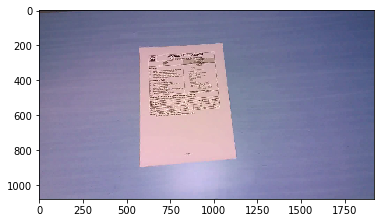

In [149]:
plot(imgs[0])

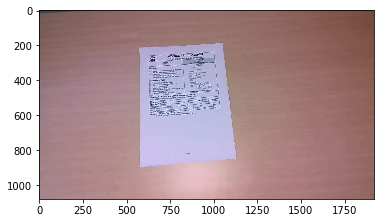

In [257]:
plot(im)

In [267]:
points = [ 580,  220,  580,  880, 1120,  840, 1040,  190]
out_shape = [600,500]
h,w = out_shape
tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y = points
pts1 = np.float32([ [tl_x,tl_y], [tr_x,tr_y], [bl_x,bl_y], [br_x,br_y] ])
pts2 = np.float32([ [0, 0], [w, 0], [0, h], [w, h] ])

In [268]:
matrix = cv2.getPerspectiveTransform(pts1, pts2)
result = cv2.warpPerspective(im, matrix, (w, h))

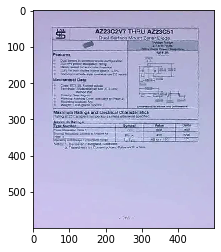

In [269]:
plot(result)

## Example w/out unet

In [273]:
im = imgs[0]
im = im[ :, :, [2,1,0] ] # BGR -> RGB

p = PaperCornerPredictor()
print('trained shape:', p.train_shape)
pts = p.predict_corners(tensor(im), shape='train')
pts

trained shape: (108, 192)


tensor([ 580,  220,  580,  880, 1110,  850, 1040,  190])

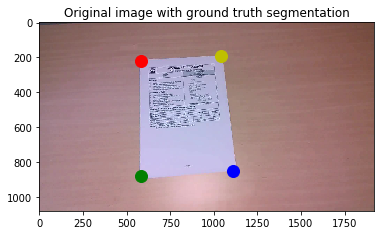

In [274]:
show_points_on_mask(im, pts)

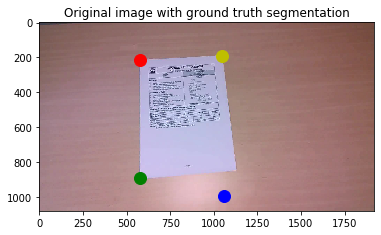

In [238]:
pts = p.predict_corners(tensor(im), shape=(200,200))
show_points_on_mask(im, pts)

## Example w/ unet

In [239]:
im = imgs[0]
im = im[ :, :, [2,1,0] ] # BGR -> RGB

p = PaperCornerPredictor(use_unet=True, use_gpu=False)
pts = p.predict_corners(tensor(im), shape='train')
pts

tensor([ 580,  220,  580,  880, 1120,  840, 1040,  190])

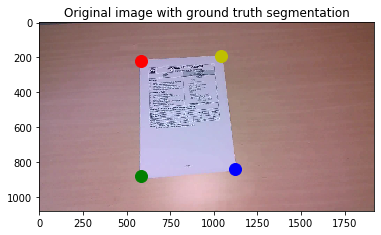

In [240]:
show_points_on_mask(im, pts)

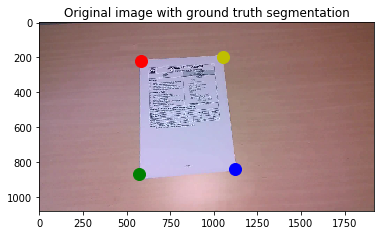

In [241]:
pts = p.predict_corners(tensor(im), shape=(200,200))
show_points_on_mask(im, pts)

## Times

In [245]:
%%timeit
p = PaperCornerPredictor(use_unet=True, use_gpu=False)
pts = p.predict_corners(tensor(im), shape='train')

85.7 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [253]:
%%timeit
p = PaperCornerPredictor(use_unet=True, use_gpu=False)
pts = p.predict_corners(tensor(im), shape=(1080,1920))

99.2 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [250]:
%%timeit
p = PaperCornerPredictor(use_unet=True, use_gpu=True)
pts = p.predict_corners(tensor(im), shape='train')

50.3 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [252]:
%%timeit
p = PaperCornerPredictor(use_unet=True, use_gpu=True)
pts = p.predict_corners(tensor(im), shape=(1080,1920))

64.5 ms ± 61.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Perspective transform

<IPython.core.display.Javascript object>


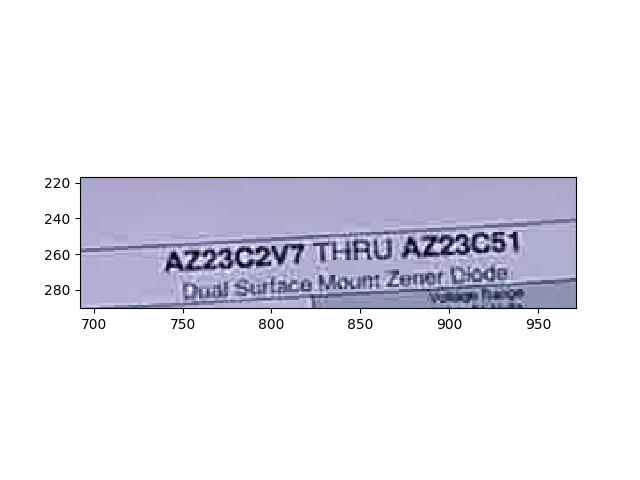

In [281]:
plot(im)

<IPython.core.display.Javascript object>


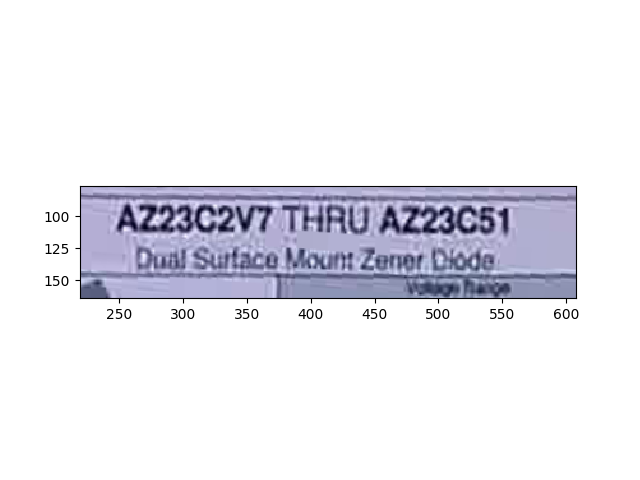

In [280]:
transformed_im = p.transform_image(im, pts, out_shape=[1080,720])
%matplotlib notebook
plot(transformed_im)